In [98]:
suppressMessages(library(tidyverse))
suppressMessages(library(tidymodels))
suppressMessages(library(readxl))
suppressMessages(library(repr))
suppressMessages(library(themis))

set.seed(1984)

In [99]:
TreeCoverLoss <- read_csv("treecover_loss_by_region__ha.csv") |>
                    select(-gfw_gross_emissions_co2e_all_gases__Mg)

colnames(TreeCoverLoss) <- c("iso", "year", "tree_cover_loss_ha")

TreeCoverLoss <- mutate(TreeCoverLoss, year = as.integer(year))

CorruptionIndex <- read_excel("CPI.xlsx", skip = 2, sheet = 2)

colnames(CorruptionIndex) <- c("country", "iso", "2020", "2019", "2018", "2017",
                               "2016", "2015", "2014", "2013", "2012", "region")

CPI_long <- pivot_longer(CorruptionIndex, 3:11, names_to = "year",
                                          values_to = "CPI") |>
                select(-country) |>
                mutate(year = as.integer(year)) |> 
                filter(region == "SSA")

Rows: 3967 Columns: 4

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (1): iso
dbl (3): umd_tree_cover_loss__year, umd_tree_cover_loss__ha, gfw_gross_emiss...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Joining, by = c("iso", "year")



iso,year,tree_cover_loss_ha,region,CPI
<chr>,<int>,<dbl>,<chr>,<dbl>
AGO,2012,1.807548e+05,SSA,22
BDI,2012,8.711629e+02,SSA,19
BEN,2012,2.865412e+03,SSA,36
BFA,2012,3.777339e-01,SSA,38
BWA,2012,1.578724e+01,SSA,65
CAF,2012,5.731389e+04,SSA,26


[1] 369

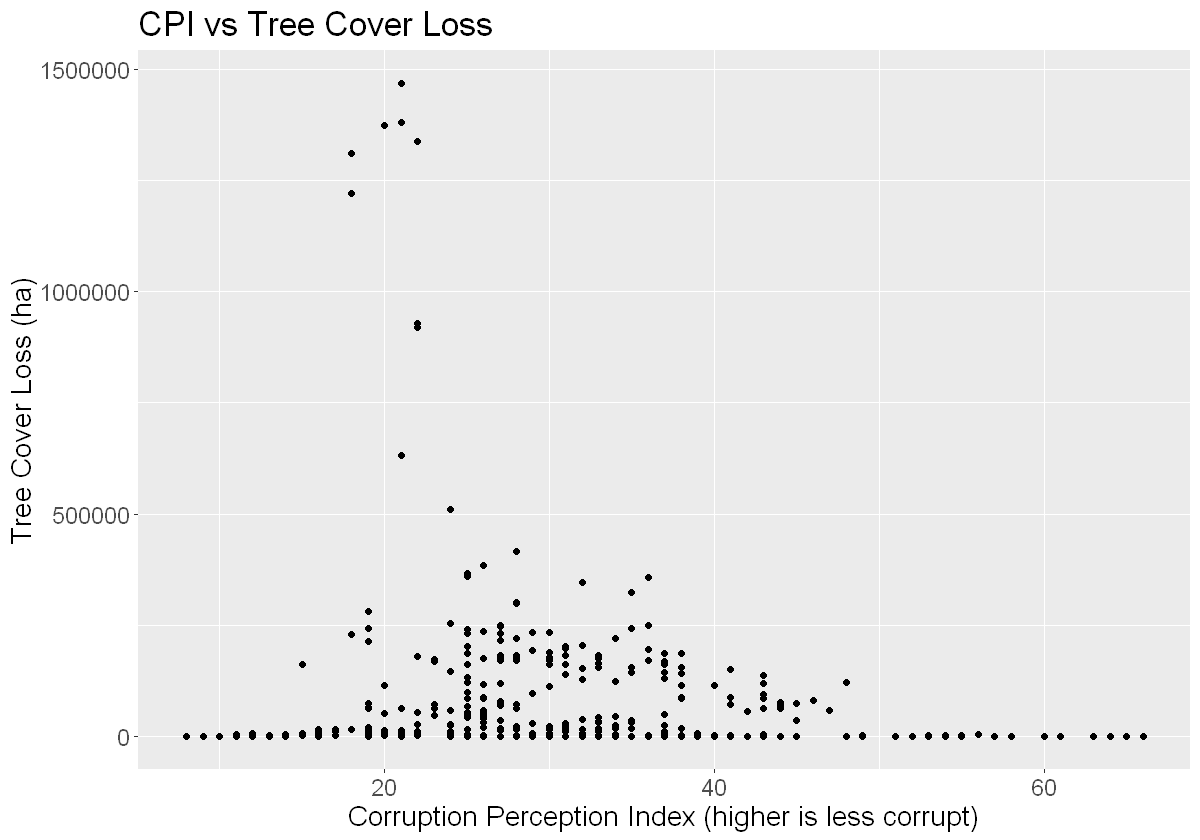

In [100]:
CPI_Trees <- left_join(TreeCoverLoss, CPI_long) |>
                na.omit()
                # filter(tree_cover_loss_ha > 90000)
head(CPI_Trees)

options(repr.plot.length = 10, repr.plot.width = 10)

CPIvsTrees <- ggplot(CPI_Trees, aes(x = CPI, y = tree_cover_loss_ha)) +
                geom_point() +
                # geom_smooth(se = FALSE) +
                # scale_y_log10() +
                labs(x = "Corruption Perception Index (higher is less corrupt)",
                     y = "Tree Cover Loss (ha)", title = "CPI vs Tree Cover Loss") +
                theme(text = element_text(size = 17))

nrow(CPI_Trees)
CPIvsTrees

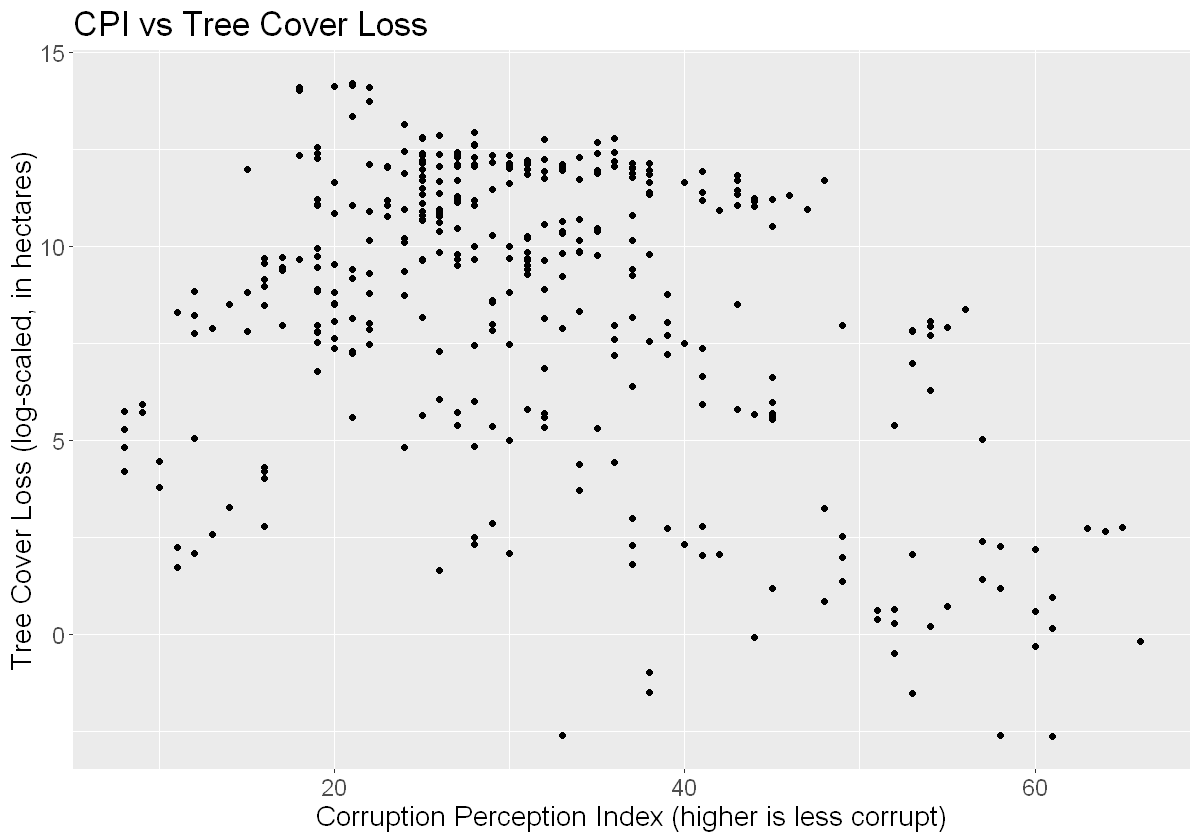

In [102]:
CPI_Trees_log <- mutate(CPI_Trees, tree_cover_loss_ha = log(tree_cover_loss_ha))

CPIvsTrees <- ggplot(CPI_Trees_log, aes(x = CPI, y = tree_cover_loss_ha)) +
                geom_point() +
                # geom_smooth(se = FALSE) +
                # scale_y_log10() +
                labs(x = "Corruption Perception Index (higher is less corrupt)",
                     y = "Tree Cover Loss (log-scaled, in hectares)", title = "CPI vs Tree Cover Loss") +
                theme(text = element_text(size = 17))

CPIvsTrees

In [103]:
set.seed(1984)

grid_vals <- tibble("neighbors" = seq(1, 50, by = 1))

split <- initial_split(CPI_Trees_log, prop = .75, strata = tree_cover_loss_ha)

CPI_Trees_training <- training(split)
CPI_Trees_testing <- testing(split)

CPI_vfold <- vfold_cv(CPI_Trees_training, v = 3, strata = tree_cover_loss_ha)

CPI_recipe_scaled <- recipe(tree_cover_loss_ha ~ CPI, data = CPI_Trees_training) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

knn_reg_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")

tune_metrics <- workflow() |>
        add_model(knn_reg_tune) |>
        add_recipe(CPI_recipe_scaled) |>
        tune_grid(CPI_vfold, grid = grid_vals) |>
        collect_metrics() |>
        filter(.metric == "rmse") |>
        arrange(mean)


In [104]:
best_k <- slice(tune_metrics, 1) |>
            select(neighbors) |>
            pull()

knn_reg <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                set_engine("kknn") |>
                set_mode("regression")

prediction_results <- workflow() |>
        add_model(knn_reg) |>
        add_recipe(CPI_recipe_scaled) |>
        fit(CPI_Trees_training) |>
        predict(CPI_Trees_testing) |>
        bind_cols(CPI_Trees_testing) 

prediction_metrics <- prediction_results |>
        metrics(truth = tree_cover_loss_ha, estimate = .pred)

prediction_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.3364056
rsq,standard,0.2827885
mae,standard,2.5253344


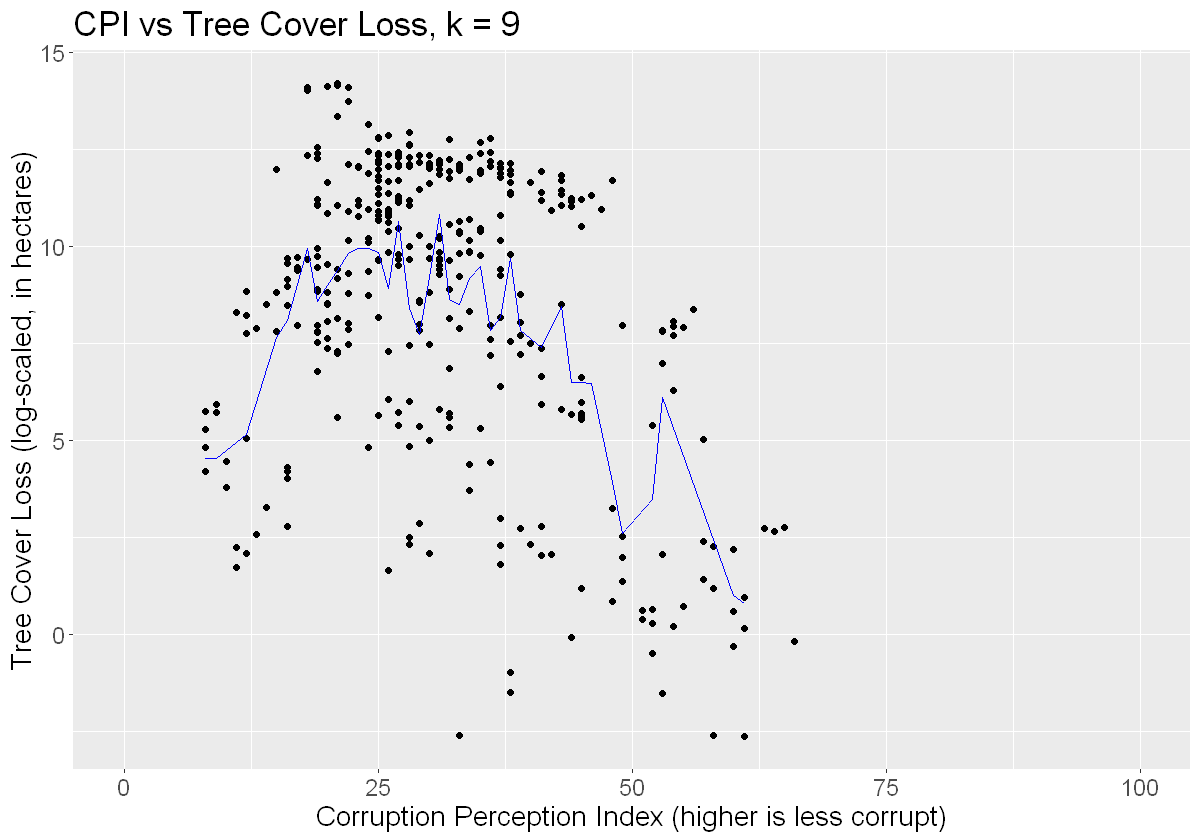

In [105]:
CPIvsTreesKNN <- ggplot(CPI_Trees_log, aes(x = CPI, y = tree_cover_loss_ha)) +
                geom_point() +
                geom_line(data = prediction_results, aes(x = CPI, y = .pred), color = "blue") +
                # scale_y_log10() +
                labs(x = "Corruption Perception Index (higher is less corrupt)",
                     y = "Tree Cover Loss (log-scaled, in hectares)", title = paste("CPI vs Tree Cover Loss, k =", best_k, sep= " ")) +
                theme(text = element_text(size = 17)) +
                xlim(0, 100) 
                     
CPIvsTreesKNN

In [107]:
mean(CPI_Trees_log$tree_cover_loss_ha)

[1] 8.568809

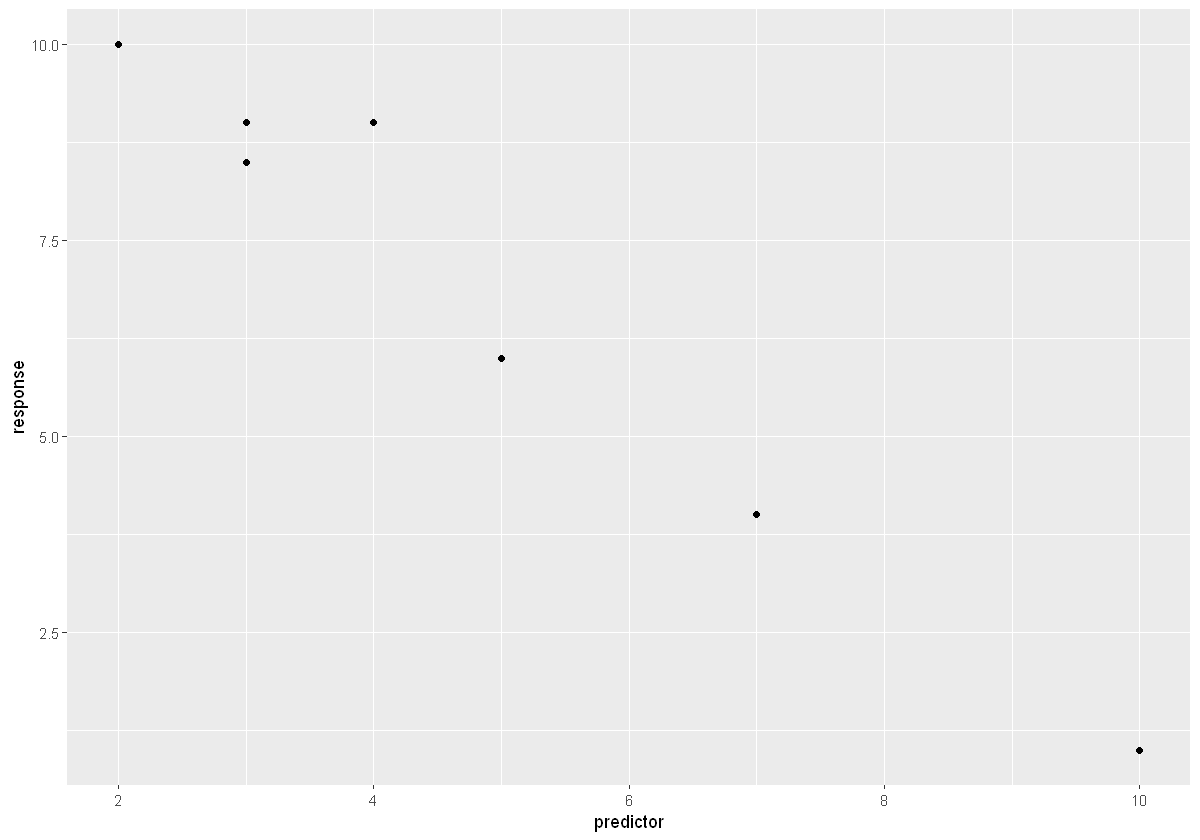

In [108]:
tibble("predictor" = c(2, 3, 3, 4, 5, 7, 10), "response" = c(10, 9, 8.5, 9, 6, 4, 1)) |>
ggplot(aes(x = predictor, y = response)) +
geom_point()

In [111]:
lm_reg <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

CPI_recipe <- recipe(tree_cover_loss_ha ~ CPI, data = CPI_Trees_training)

prediction_results_lm <- workflow() |>
        add_model(lm_reg) |>
        add_recipe(CPI_recipe) |>
        fit(CPI_Trees_training) |>
        predict(CPI_Trees_testing) |>
        bind_cols(CPI_Trees_testing)

prediction_results_lm_metrics <- prediction_results_lm |>
        metrics(truth = tree_cover_loss_ha, estimate = .pred)

prediction_results_lm_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.5161681
rsq,standard,0.2077575
mae,standard,2.8767663


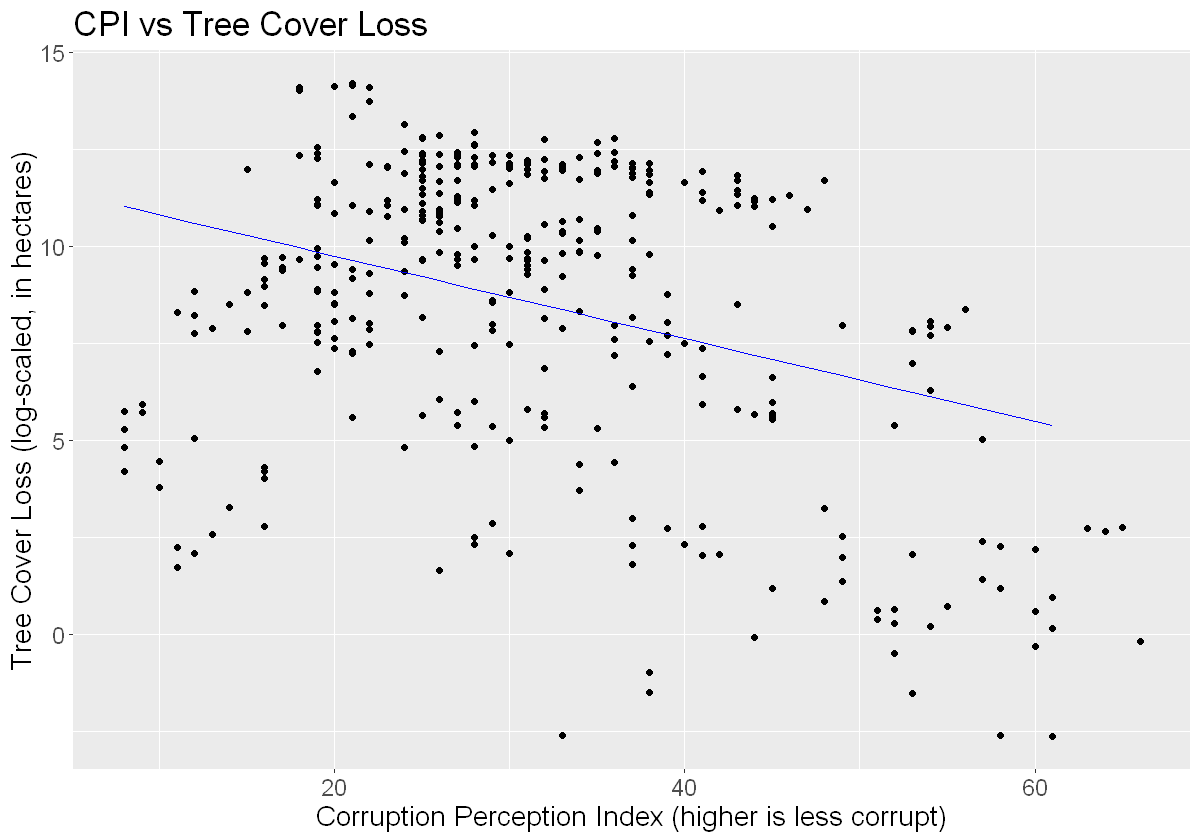

In [112]:
CPIvsTreesLM <- ggplot(CPI_Trees_log, aes(x = CPI, y = tree_cover_loss_ha)) +
                geom_point() +
                geom_line(data = prediction_results_lm, aes(x = CPI, y = .pred), color = "blue") +
                # scale_y_log10() +
                labs(x = "Corruption Perception Index (higher is less corrupt)",
                     y = "Tree Cover Loss (log-scaled, in hectares)", title = "CPI vs Tree Cover Loss") +
                theme(text = element_text(size = 17))

CPIvsTreesLM